# Pewlett Hackard Employee Data Visualizations

## _Importing the Database_

In [1]:
#Add dependencies
import pprint
import pandas as pd
import sqlalchemy
import psycopg2
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

In [2]:
#Link and prepare database
from config import username, password, host, port, database
from sqlalchemy import create_engine
engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}')
go = engine.connect()

## Find & Merge Data

In [3]:
#Ensure all database tables are connected
engine.table_names()

['employees2', 'dept_emp', 'departments', 'dept_manager', 'titles', 'salaries']

In [4]:
#Find, filter, and merge data from tables using SQL
search = """select salaries.emp_no, salary, title from salaries
	inner join employees2 on salaries.emp_no = employees2.emp_no
	inner join titles on employees2.emp_title_id = titles.title_id
	order by emp_no;"""

In [5]:
#Convert SQL to pandas dataframe
salary_data = pd.read_sql(search, go)
salary_data.head()

,emp_no,salary,title
0,10001,60117,Senior Engineer
1,10002,65828,Staff
2,10003,40006,Senior Engineer
3,10004,40054,Senior Engineer
4,10005,78228,Staff


## Histogram Visualiztion

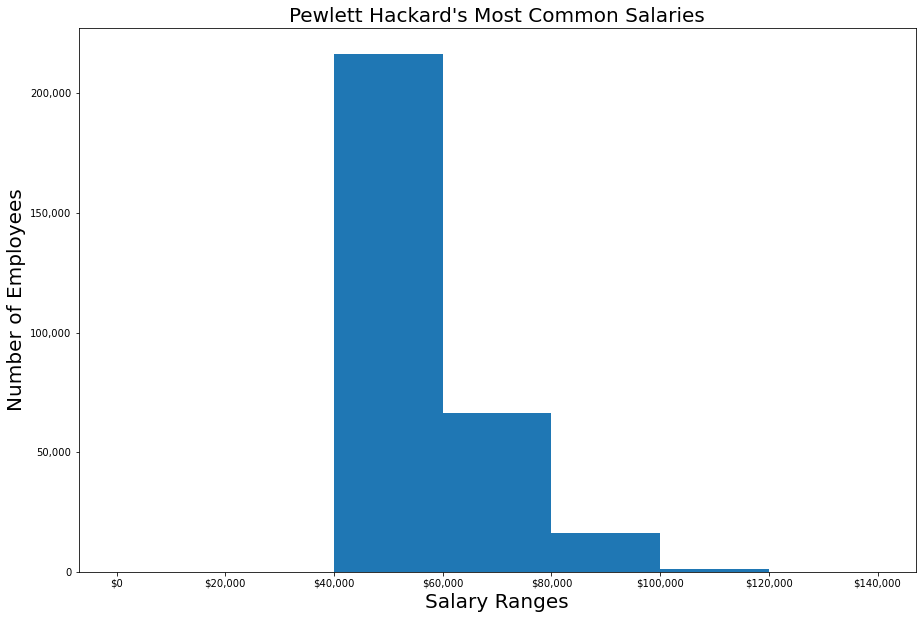

In [6]:
#Plot Histogram of salary_data dataframe
fig, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.hist(salary_data['salary'], bins=[0,40000,60000,80000,100000,120000,140000])
plt.xlabel('Salary Ranges', fontsize=20)
plt.ylabel('Number of Employees',fontsize=20)
plt.title("Pewlett Hackard's Most Common Salaries",fontsize=20)
plt.savefig("salary_range_histogram.png")
plt.show()

## Bar Chart Visualization

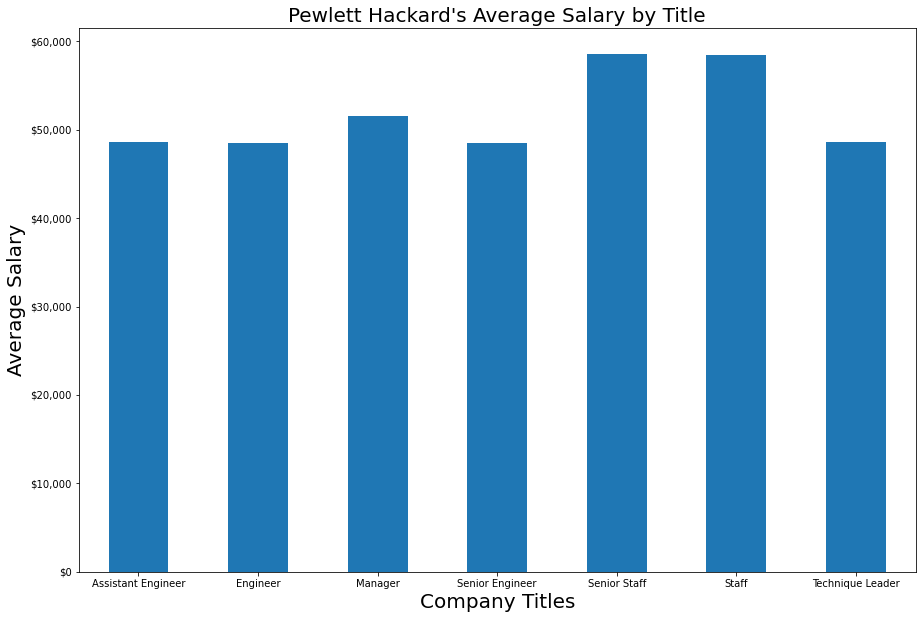

In [7]:
#Plot bar chart of salary_data filtered dataframe
average = salary_data.groupby(['title'])['salary'].mean()
ax1 = average.plot.bar(rot=0,figsize=(15,10))
ax1.get_yaxis().set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlabel('Company Titles', fontsize=20)
plt.ylabel('Average Salary',fontsize=20)
plt.title("Pewlett Hackard's Average Salary by Title",fontsize=20)
plt.savefig("salary_title_bar.png")
plt.show()

## Employee ID Badge Check

In [8]:
badgecheck = salary_data.loc[salary_data['emp_no']==499942]
badgecheck

,emp_no,salary,title
299966,499942,40000,Technique Leader


### _Salary Range by Title Breakdown & Analysis Confirmation_

In [9]:
#Place salaries table from database in dataframe
sal = pd.read_sql('select * from salaries', go)
sal.head()

,emp_no,salary
0,10001,60117
1,10002,65828
2,10003,40006
3,10004,40054
4,10005,78228


In [10]:
#Bring employee data from database into dataframe
employ = pd.read_sql('select emp_no, emp_title_id from employees2', go)
employ.head()

,emp_no,emp_title_id
0,473302,s0001
1,475053,e0002
2,57444,e0002
3,421786,s0001
4,282238,e0003


In [11]:
#Bring titles data from database into dataframe
titles = pd.read_sql('select * from titles', go)
titles.head()

,title_id,title
0,s0001,Staff
1,s0002,Senior Staff
2,e0001,Assistant Engineer
3,e0002,Engineer
4,e0003,Senior Engineer


In [12]:
#Merge salary table and employee data information
merge = pd.merge(sal, employ, on="emp_no")
change= merge.rename(columns = {"emp_title_id":"title_id"})
change.head()

,emp_no,salary,title_id
0,10001,60117,e0003
1,10002,65828,s0001
2,10003,40006,e0003
3,10004,40054,e0003
4,10005,78228,s0001


In [13]:
#Merge salary table and employee data information
data = pd.merge(change, titles, on="title_id")
data.head()

,emp_no,salary,title_id,title
0,10001,60117,e0003,Senior Engineer
1,10003,40006,e0003,Senior Engineer
2,10004,40054,e0003,Senior Engineer
3,10006,40000,e0003,Senior Engineer
4,10009,60929,e0003,Senior Engineer


In [14]:
#Create dataframe to view overall salary trends
summary = data.groupby('title').agg({'emp_no':['count', 'nunique'],
                                               'salary':['min','max','mean','median']})
summary

emp_no         salary                               
                     count nunique    min     max          mean   median
title                                                                   
Assistant Engineer    5835    5835  40000   99683  48564.434447  44588.0
Engineer             47303   47303  40000  100683  48535.336511  44478.0
Manager                 24      24  40000   72446  51531.041667  48458.5
Senior Engineer      97747   97747  40000  110449  48506.799871  44502.0
Senior Staff         26583   26583  40000  127238  58550.172704  56585.0
Staff               107384  107384  40000  129492  58465.382850  56407.0
Technique Leader     15148   15148  40000  104065  48582.896092  44546.0

In [15]:
#Create custom ranges and labels for groupby salaries based on employee title in bins
salaryranges = [0,39999.99999,60000,80000,100000,120000,9999999]
salarylabels = ["<$40,000","$40,000-$60,000","$60,000-$80,000","$80,000-$100,00","$100,00-$120,000","$120,000+"]

In [16]:
#Find per employee salary data from merged table and place them into ranges
employee_ranges = data["salary"]=pd.cut(data["salary"], salaryranges,labels=salarylabels)

In [17]:
#Group merged data by salary and count by employee 
salary_summary = data.groupby(employee_ranges)['emp_no'].count()

In [18]:
#Create dataframe with merged, grouped, and counted salary data
pd.options.display.html.use_mathjax = False
salary_distribution = pd.DataFrame(salary_summary)
salary_distribution

,emp_no
salary,
"<$40,000",0
"$40,000-$60,000",216389
"$60,000-$80,000",66219
"$80,000-$100,00",16129
"$100,00-$120,000",1263
"$120,000+",24
